In [ ]:
#https://towardsdatascience.com/using-signal-processing-to-extract-neural-events-in-python-964437dc7c0

# Using signal processing and K-means clustering to extract and sort neural events in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
%matplotlib inline


#define data path
data_file = "..../UCLA_data/CSC4.Ncs"

In [2]:
#Header has 16 kilobytes length
header_size = 16 * 1024

#open file
fid = open(data_file, 'rb')

#skip the header by shifting positions by header size
fid.seek(header_size)

#Read data according to Neuralynx information
data_format = np.dtype([('TimeStamp', np.uint64),
                       ('ChannelNumber', np.uint32),
                       ('SampleFreq', np.uint32),
                       ('NumValidSamples', np.uint32),
                        ('Samples', np.int16, 512)])

raw = np.fromfile(fid, dtype=data_format)

#Close file
fid.close()

#Get sampling frequency
sf = raw['SampleFreq'][0]

#Create Data vector
data = raw['Samples'].ravel()

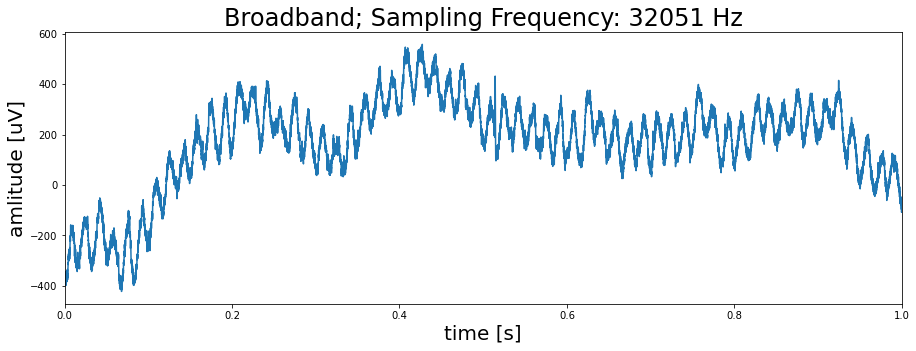

In [3]:
#Determine duration of recording in seconds
dur_sec = data.shape[0]/sf

#create time vector
time = np.linspace(0, dur_sec, data.shape[0])

#Plot first second of data
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(time[0:sf], data[0:sf])
ax.set_title('Broadband; Sampling Frequency: {} Hz'.format(sf), fontsize=24)
ax.set_xlim(0, time[sf])
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('amlitude [uV]', fontsize=20)
plt.show()

# Bandpass filter the data


The function below will bandpass filter the signal to exclude the 60Hz domain.

In [4]:
def filter_data (data, low, high=9000, sf, order=2):
    nyq = sf/2
    #determined Nyquist frequency
    
    #set bands
    low = low/nyq
    high = high/nyq
    
    #calculate coefficients
    b, a = butter(order, [low, high], btype='band')
    
    #Filter signal
    filtered_data = lfilter(b, a, data)
    
    return filtered_data

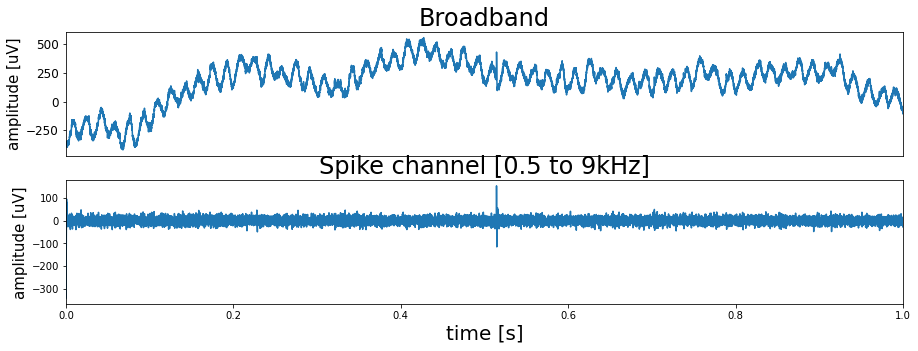

In [7]:
spike_data = filter_data(data, low=500, high=9000, sf=sf)

# Plot signals
fig, ax = plt.subplots(2, 1, figsize=(15, 5))
ax[0].plot(time[0:sf], data[0:sf])
ax[0].set_xticks([])
ax[0].set_title('Broadband', fontsize=24)
ax[0].set_xlim(0, time[sf])
ax[0].set_ylabel('amplitude [uV]', fontsize=15)
ax[0].tick_params(labelsize=12)

ax[1].plot(time[0:sf], spike_data[0:sf])
ax[1].set_title('Spike channel [0.5 to 9kHz]', fontsize=24)
ax[1].set_xlim(0, time[sf])
ax[1].set_xlabel('time [s]', fontsize=20)
ax[1].set_ylabel('amplitude [uV]', fontsize=15)
ax[1].tick_params( spikes labelsize=10)
plt.show()

# Extract Spikes from the filtered signal
We will identify and extract spikes

Inputs:
    1. Filtered Data
    2. No of Samples
    3. Threshold Factor
    4. Upper Threshold
    5. Offset Data